# Accessing DC2 forced source data in PostgreSQL at NERSC

In [1]:
import psycopg2
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd

Make the db connection

In [2]:
dbname = 'desc_dc2_drp'
dbuser = 'desc_dc2_drp_user'
dbhost = 'nerscdb03.nersc.gov'
dbconfig = {'dbname' : dbname, 'user' : dbuser, 'host' : dbhost}
dbconn = psycopg2.connect(**dbconfig)

In [3]:
schema = 'run12p_v4'   # Currently (May 2019) only dataset with forced source 

Display all tables and views belonging to the schema.  Most of them are for the object catalog

In [4]:
q1 = "SELECT DISTINCT table_name FROM information_schema.columns WHERE table_schema='{schema}' ORDER BY table_name".format(**locals())
with dbconn.cursor() as cursor:
    # Could have several queries interspersed with other code in this block
    cursor.execute(q1)
    for record in cursor:
        print(record[0])

ccdvisit
dpdd
dpdd_forced
dpdd_qserv
dpdd_ref
forced2
forced3
forced4
forced5
forcedsource
forcedsourcenative
forcedsource_qserv
misc_ref
position
_temp:forced_bit
_temp:forced_patch


### Where Forced Source data can be found

**\_temp:forced\_patch** and **\_temp:forced_bit** are artifacts of the ingest process and are of no interest here.

forcedsourcenative has columns from the forced source data most likely to be of interest. These include objectid (identical in meaning to its use in the object catalog) and ccdvisitid.  ccdvisitid uniquely identifies a row in the ccdvisit table and is computed from visit, raft and sensor ids. 

In [5]:
tbl = 'forcedsourcenative'
q2 = "SELECT column_name, data_type FROM information_schema.columns WHERE table_schema='{schema}' AND table_name='{tbl}' order by column_name ".format(**locals())
print(q2)
with dbconn.cursor() as cursor:
    cursor.execute(q2)
    records = cursor.fetchall()
    print("There are {} columns in table {}.  They are:\n".format(len(records), tbl))
    print("Name                                                     Data Type")
    for record in records:
        print("{0!s:55}  {1!s:20}".format(record[0], record[1]) )

SELECT column_name, data_type FROM information_schema.columns WHERE table_schema='run12p_v4' AND table_name='forcedsourcenative' order by column_name 
There are 20 columns in table forcedsourcenative.  They are:

Name                                                     Data Type
base_pixelflags_flag                                     boolean             
base_pixelflags_flag_bad                                 boolean             
base_pixelflags_flag_cr                                  boolean             
base_pixelflags_flag_crcenter                            boolean             
base_pixelflags_flag_edge                                boolean             
base_pixelflags_flag_interpolated                        boolean             
base_pixelflags_flag_interpolatedcenter                  boolean             
base_pixelflags_flag_offimage                            boolean             
base_pixelflags_flag_saturated                           boolean             
base_pixelflags_fl

Here is a similar query for the **ccdvisit** table.

In [6]:
tbl = 'ccdvisit'
q2_pos = "SELECT column_name, data_type FROM information_schema.columns WHERE table_schema='{schema}' AND table_name='{tbl}'".format(**locals())
with dbconn.cursor() as cursor:
    cursor.execute(q2_pos)
    records = cursor.fetchall()
    print("There are {} columns in table {}.  They are:\n".format(len(records), tbl))
    print("Name                                                     Data Type")
    for record in records:
        print("{0!s:55}  {1!s:20}".format(record[0], record[1]) )

There are 12 columns in table ccdvisit.  They are:

Name                                                     Data Type
ccdvisitid                                               bigint              
visitid                                                  integer             
ccdname                                                  character           
raftname                                                 character           
filtername                                               character           
obsstart                                                 timestamp without time zone
expmidpt                                                 double precision    
exptime                                                  double precision    
zeropoint                                                real                
seeing                                                   real                
skybg                                                    real                
skynoise        

Of these columns two (`expmidpt`, `exptime`) are, in this data set, always null. For many purposes `ccdname` and `raftname` are of no interest and `visitid` is encompassed by `ccdvisitid`. 

Here is a query which finds all visits.  The example only prints out the total number.

In [7]:
q3 = "SELECT DISTINCT visitid FROM {schema}.ccdvisit".format(**locals())
with dbconn.cursor() as cursor:
    %time cursor.execute(q3)
    records = cursor.fetchall()
    print("{} visits found".format(len(records)))
 

CPU times: user 0 ns, sys: 2.54 ms, total: 2.54 ms
Wall time: 722 ms
1991 visits found


The view `forcedsource` selects fields of interest from `forcedsourcenative`, `ccdvisit` and the object catalog. This query fetches all its fields.

In [8]:
tbl = 'forcedsource'
q4 = "SELECT column_name, data_type FROM information_schema.columns WHERE table_schema='{schema}' AND table_name='{tbl}'".format(**locals())
with dbconn.cursor() as cursor:
    cursor.execute(q4)
    records = cursor.fetchall()
    print("There are {} columns in view {}.  They are:\n".format(len(records), tbl))
    print("Name                                                     Data Type")
    for record in records:
        print("{0!s:55}  {1!s:20}".format(record[0], record[1]) )    

There are 47 columns in view forcedsource.  They are:

Name                                                     Data Type
objectid                                                 bigint              
ccdvisitid                                               bigint              
ra                                                       double precision    
dec                                                      double precision    
extendedness                                             real                
blendedness                                              real                
filtername                                               character           
obsstart                                                 timestamp without time zone
psflux_g                                                 real                
psflux_i                                                 real                
psflux_r                                                 real                
psflux_u     

Some explanation is in order. Most of these fields (e.g. `psflux_g`, `psflux_flag_g`, `psfluxerr_g`, `mag_g`, `magerr_g` and similar for the other bands) come from the corresponding object in the object catalog and have the same name they have in the object dpdd. `ra`, `dec` (as well as `coord`, which is a more convenient way to express location in some circumstances), `extendedness`, `blendedness`, `good`, and `clean` also come from the object catalog. (For information about dpdd quantities like clean and other fields mentioned above, see the [SCHEMA.md](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md#schema-for-dc2-coadd-catalogs) file of the LSSTDESC/gcr-catalogs repository.)

`filtername` and `obsstart` come from `ccdvisit`.  The rest all come from `forcedsourcenative` one way or another.  Some fields, such as `psflux`, come directly but have been renamed to match the names suggested for the forced source dpdd as defined in LSE-163. Others (e.g. `mag`, `magerr`) have been computed from one or more fields in `forcedsourcenative`. `forcedsourcevisit_good` is similar to `good` (meaning no flagged pixels) but uses flags from `forcedsourcenative` rather than the object catalog.

### Light curves
For this purpose first find objects with lots of visits. This query takes 5 or 6 minutes to execute, the only query in this notebook which is slow; the others all return essentially immediately. Then cut on various measures of goodness.  For the remaining objects save object id, ra, dec and extendedness. Since the query is relatively long the function writes out the data.   You can either just read in such a file or recreate it yourself by uncommenting the call to the function,
substituting something reasonable for `'some_path'`, and then skip the step which reads from a file created previously by calling the function.

In [9]:
def getGoodVisited(outpath, schema):
    '''
    Get and save information for good objects which show up in at least 400 visits
    
    Parameters
    ----------
    outpath : str          Path to output csv file
    schema :  str          Database schema in which data are stored
    
    Returns
    -------
    Pandas data frame with certain properties for all objects making the cuts 
    '''
    # First find visit count per object
    avisited_q = 'select objectid,count(objectid) as avisit_count from {}.forcedsourcenative ' 
    avisited_q += 'group by (objectid) '
    avisited_q += 'order by avisit_count desc'
    avisited_qf = avisited_q.format(schema)
    print(avisited_qf)     # this is the time-consuming query
    avisited_records = []
    with dbconn.cursor() as cursor:
        %time cursor.execute(avisited_qf)
        avisited_records = cursor.fetchall()
    avisited_df = pd.DataFrame(avisited_records, columns=['objectid', 'visit_count'])
    print(avisited_df.shape)
    
    # Keep the ones with at least 400 visits
    over400_df = avisited_df.query('visit_count > 400')
    print(over400_df.shape)
    
    # Now query on those object in the set which also satisfy some cuts
    i_list = list(over400_df['objectid'])
    s_list = []
    for i in i_list : s_list.append(str(i))
    objectcut = ' AND objectid in (' + ','.join(s_list) + ')'

    global_cuts = 'clean '

    min_SNR = 25   
    max_err = 1/min_SNR
    band_cuts = ' (magerr_g < {max_err}) AND (magerr_i < {max_err}) AND (magerr_r < {max_err}) '.format(**locals())
    where = ' WHERE ' + global_cuts + ' AND ' + band_cuts 

    goodobjects_q = "SELECT objectid, extendedness, ra, dec, mag_i, mag_g, mag_r from {schema}.dpdd ".format(**locals()) + where + objectcut
    # Don't normally print out this query because object_cut can be a very long string. 
    records = []
    with dbconn.cursor() as cursor:
        %time cursor.execute(goodobjects_q)
        records = cursor.fetchall()
        nObj = len(records)
    
    df = pd.DataFrame(records, columns=['objectid', 'extendedness', 'ra', 'dec', 'mag_i', 'mag_g', 'mag_r'])
    print("Total: ", nObj)
    over400out = open(outpath,'w')    
    df.to_csv(over400out)
    return df


In [10]:
#  recreate good objects table
#  df = getGoodVisited('some_path', schema)

In [11]:
#  Read in good objects table
retrieve_path = '../tutorials/assets/{}-over400visits.csv'.format(schema)
df = pd.read_csv(retrieve_path)

#### Get the data
Query `forcedsource` for an entry and use the returned data to plot light curves. 

In [12]:
#   This object happens to be a star
star_ix = 1045
star_id = df['objectid'][star_ix]

In [13]:

def getlc(schema, objectid):
    q_template = 'select filtername as band,obsstart,mag,magerr from {schema}.forcedsource '   
    q_template += 'where objectid={objectid} and forcedsourcevisit_good and not psflux_flag order by filtername,obsstart'
    lc_q = q_template.format(**locals())
    print(lc_q)
    with dbconn.cursor() as cursor:
        %time cursor.execute(lc_q)
        records = cursor.fetchall()
    
    df = pd.DataFrame(records, 
                      columns=['filtername', 'obsstart', 'mag', 'magerr'])
    #print('Printing i-band data from getlc for object ', objectid)
    #iband = df[(df.filtername == 'i')]
    #for ival in list(iband['mag']): print(ival)
    
    return df

In [14]:
star_data = getlc(schema, star_id)

select filtername as band,obsstart,mag,magerr from run12p_v4.forcedsource where objectid=21326423885118366 and forcedsourcevisit_good and not psflux_flag order by filtername,obsstart
CPU times: user 1.73 ms, sys: 1.84 ms, total: 3.58 ms
Wall time: 5.04 s


In [15]:
star_data.head(star_data.shape[0])

,filtername,obsstart,mag,magerr
0,g,2022-09-17 05:19:22.051,18.651415,0.003244
1,g,2022-09-20 04:54:29.750,18.637620,0.002824
2,g,2022-10-02 05:09:06.797,18.638224,0.002789
3,g,2022-10-05 04:38:55.075,18.652247,0.003655
4,g,2022-10-15 03:58:41.405,18.639867,0.003311
...,...,...,...,...
415,z,2028-10-23 03:19:44.458,17.978046,0.004209
416,z,2028-11-11 02:28:09.696,17.971891,0.004239
417,z,2028-12-26 02:24:59.443,17.961123,0.004538
418,z,2029-09-29 06:36:27.389,17.985021,0.004129


#### Plotting

In [16]:
from astropy.time import Time
def plot_band_lc(axes, times, mags, params):
    j_times = []
    for t in times:
        tobj = Time(str(t).replace(' ', 'T'))
        tobj.format = 'jd'
        j_times.append(tobj.value)
    out = axes.scatter(np.asarray(j_times), np.asarray(mags), **params)

In [17]:
def plot_level(axes, yvalue, params):
    xmin, xmax = axes.get_xlim()
    out = axes.plot(np.asarray([xmin, xmax]), np.asarray([yvalue, yvalue]), **params)

In [18]:
def format_title(df, ix):
        ra = df['ra'][ix]
        dec = df['dec'][ix]
        oid = df['objectid'][ix]
        if df['extendedness'][ix] > 0.5:
            prefix = 'Extended object'
        else:
            prefix = 'Star '
        return '{prefix} light curve for object {oid} at ra={ra}, dec={dec}'.format(**locals())

In [19]:
def plot_object(title, the_data, coadd_mag):
    '''
    Plot r, g and i light 'curves' (as scatter plot) for an object. Also plot coadd magnitudes for each band. 
    Parameters
    -----------
    title : string
    the_data : data frame which must include columns filtername, obsstart, mag
    coadd_mag : dict associating magnitude from coadd with filtername
    '''
    good_d = the_data[(np.isnan(the_data.mag)==False)]
    red_d = good_d[(good_d.filtername=="r")]
    green_d = good_d[(good_d.filtername=="g")]
    i_d = good_d[(good_d.filtername=="i")]
    #print("red data shape: ", red_e.shape, "   green data shape: ", green_e.shape, "  i data shape: ", i_e.shape)
    fix, axes = plt.subplots(figsize=(12,8))

    plt.title(title)
    plt.xlabel('Julian date')
    plt.ylabel('Magnitude')

    params_r = {'marker' : 'o', 'label' : 'r band', 'color' : 'red'}
    #print('In plot_object printing i-band values')
    #for ival in list(i_d['mag']): print(ival)
    plot_band_lc(axes, list(red_d['obsstart']), list(red_d['mag']), params_r)
    params_g = {'marker' : 'o', 'label' : 'g band', 'color' : 'green'}
    plot_band_lc(axes, list(green_d['obsstart']), list(green_d['mag']), params_g)
    params_i = {'marker' : 'o', 'label' : 'i band', 'color' : 'orange'}
    plot_band_lc(axes, list(i_d['obsstart']), list(i_d['mag']), params_i)
    plot_level(axes, coadd_mag['r'], {'label' : 'r coadd mag', 'color' : 'red'})
    plot_level(axes, coadd_mag['g'], {'label' : 'g coadd mag', 'color' : 'green'})
    plot_level(axes, coadd_mag['i'], {'label' : 'i coadd mag', 'color' : 'orange'})
    plt.legend()

select filtername as band,obsstart,mag,magerr from run12p_v4.forcedsource where objectid=21326423885118366 and forcedsourcevisit_good and not psflux_flag order by filtername,obsstart
CPU times: user 538 µs, sys: 666 µs, total: 1.2 ms
Wall time: 10.3 ms


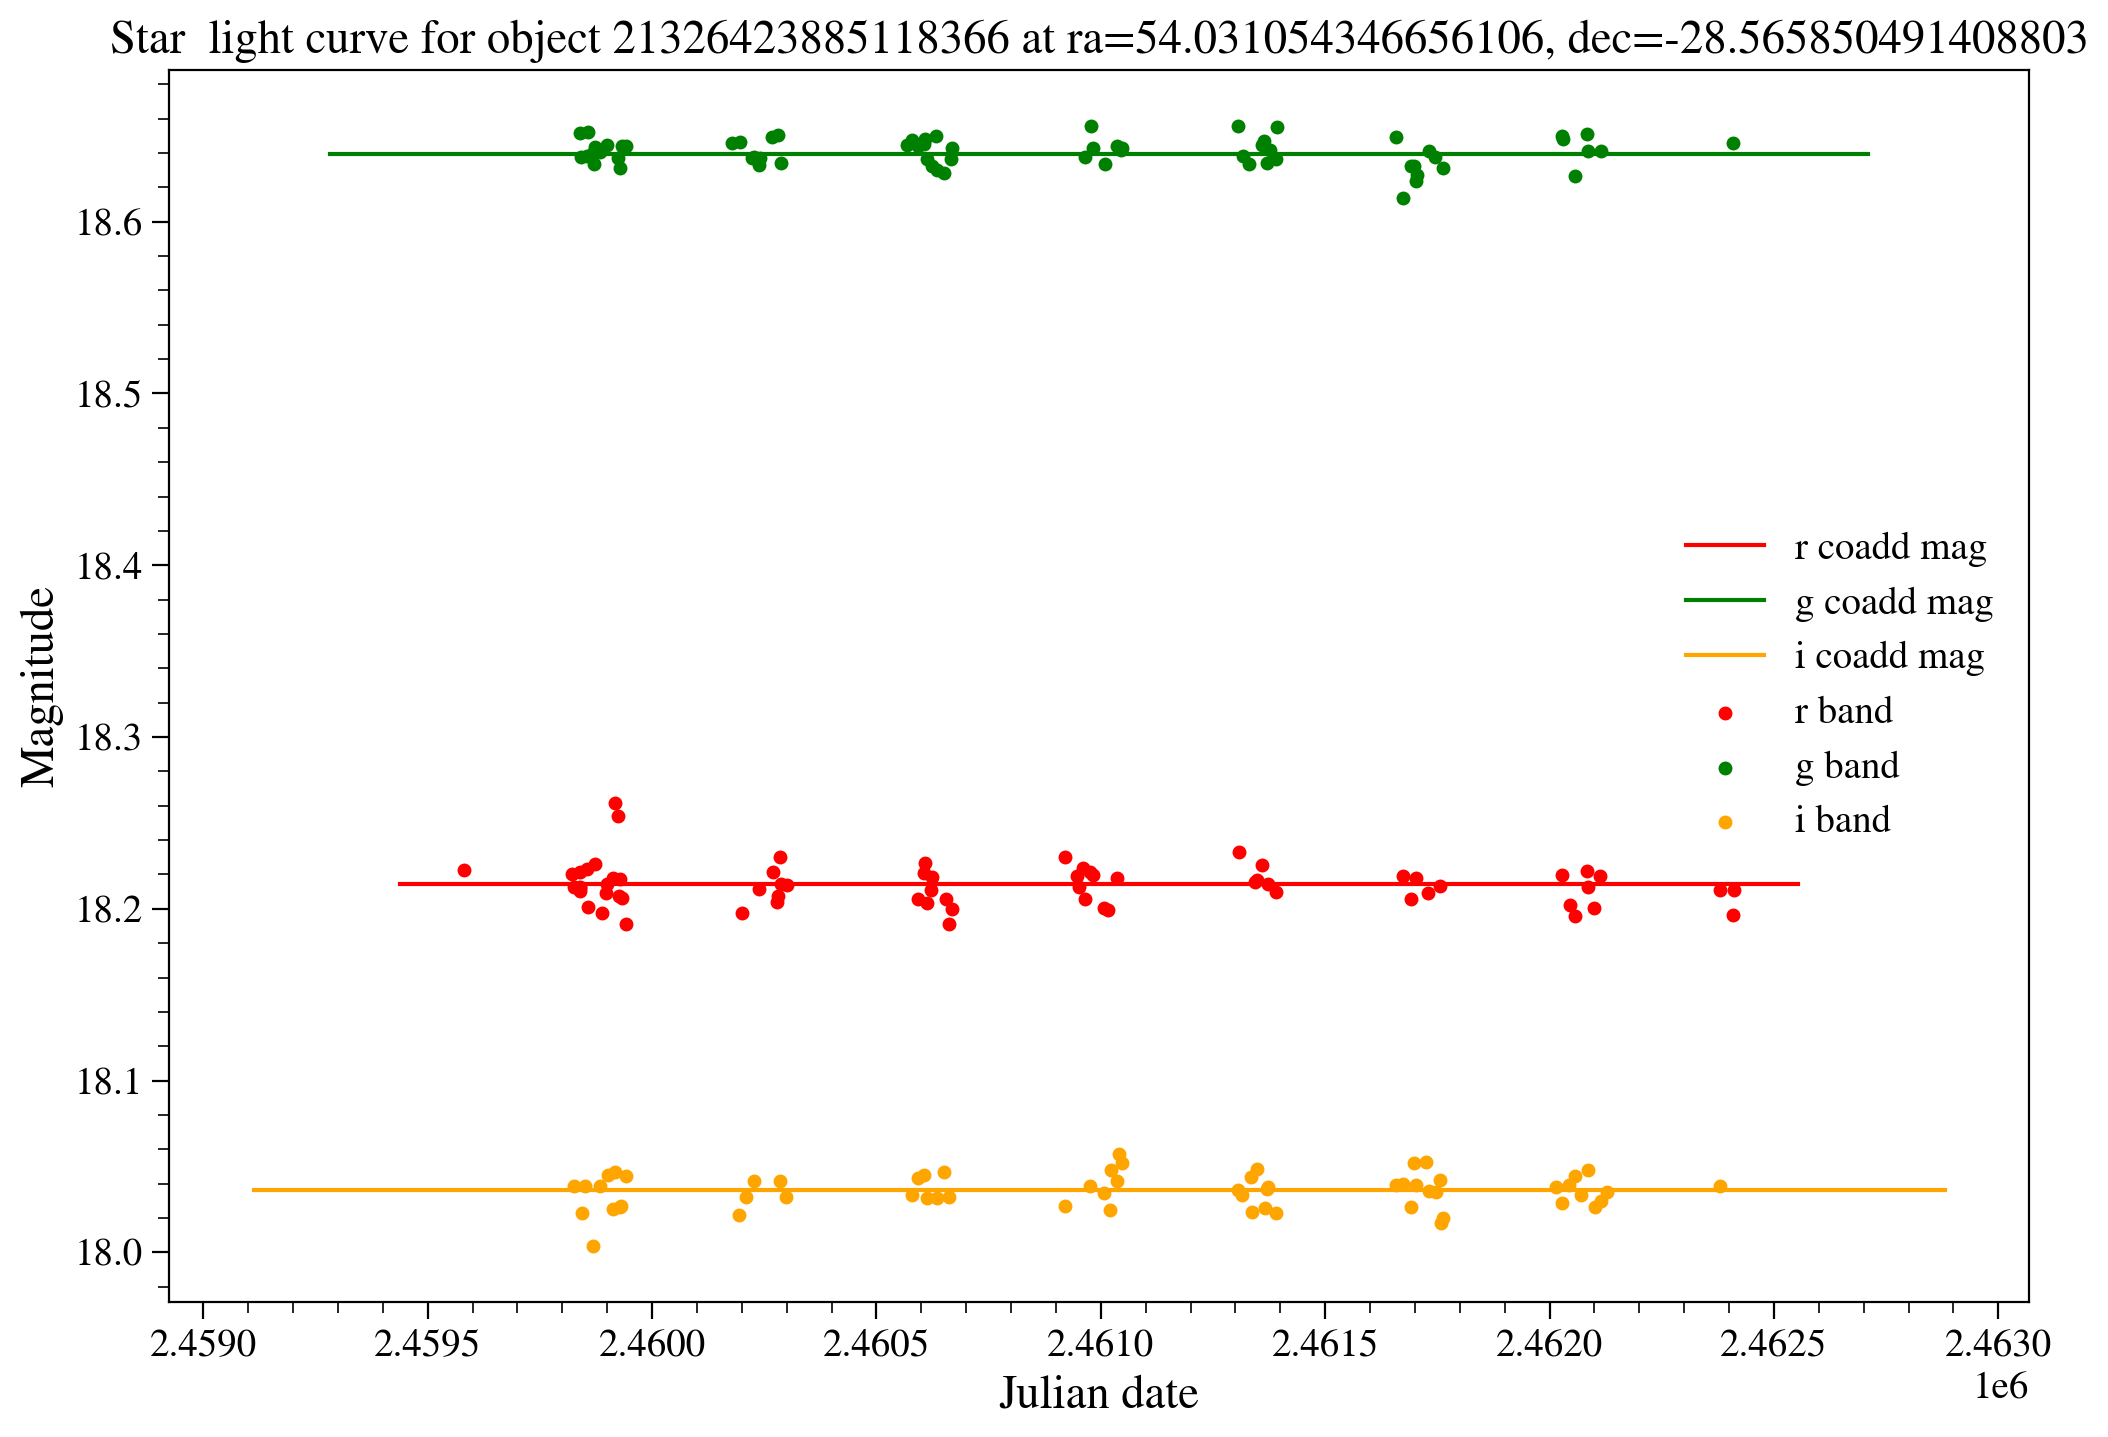

In [20]:
oid = df['objectid'][star_ix]
title = format_title(df,star_ix)
coadd_mag = {'r' : df['mag_r'][star_ix], 'g' : df['mag_g'][star_ix], 'i' : df['mag_i'][star_ix]}
the_data = getlc('run12p_v4', oid)
plot_object(title, the_data, coadd_mag)

select filtername as band,obsstart,mag,magerr from run12p_v4.forcedsource where objectid=21326282151205405 and forcedsourcevisit_good and not psflux_flag order by filtername,obsstart
CPU times: user 1.76 ms, sys: 1.68 ms, total: 3.45 ms
Wall time: 4.48 s
select filtername as band,obsstart,mag,magerr from run12p_v4.forcedsource where objectid=21326286446162352 and forcedsourcevisit_good and not psflux_flag order by filtername,obsstart


CPU times: user 1.21 ms, sys: 1.63 ms, total: 2.84 ms
Wall time: 3.69 s
select filtername as band,obsstart,mag,magerr from run12p_v4.forcedsource where objectid=21326290741101028 and forcedsourcevisit_good and not psflux_flag order by filtername,obsstart


CPU times: user 11 µs, sys: 3.96 ms, total: 3.97 ms
Wall time: 4.21 s


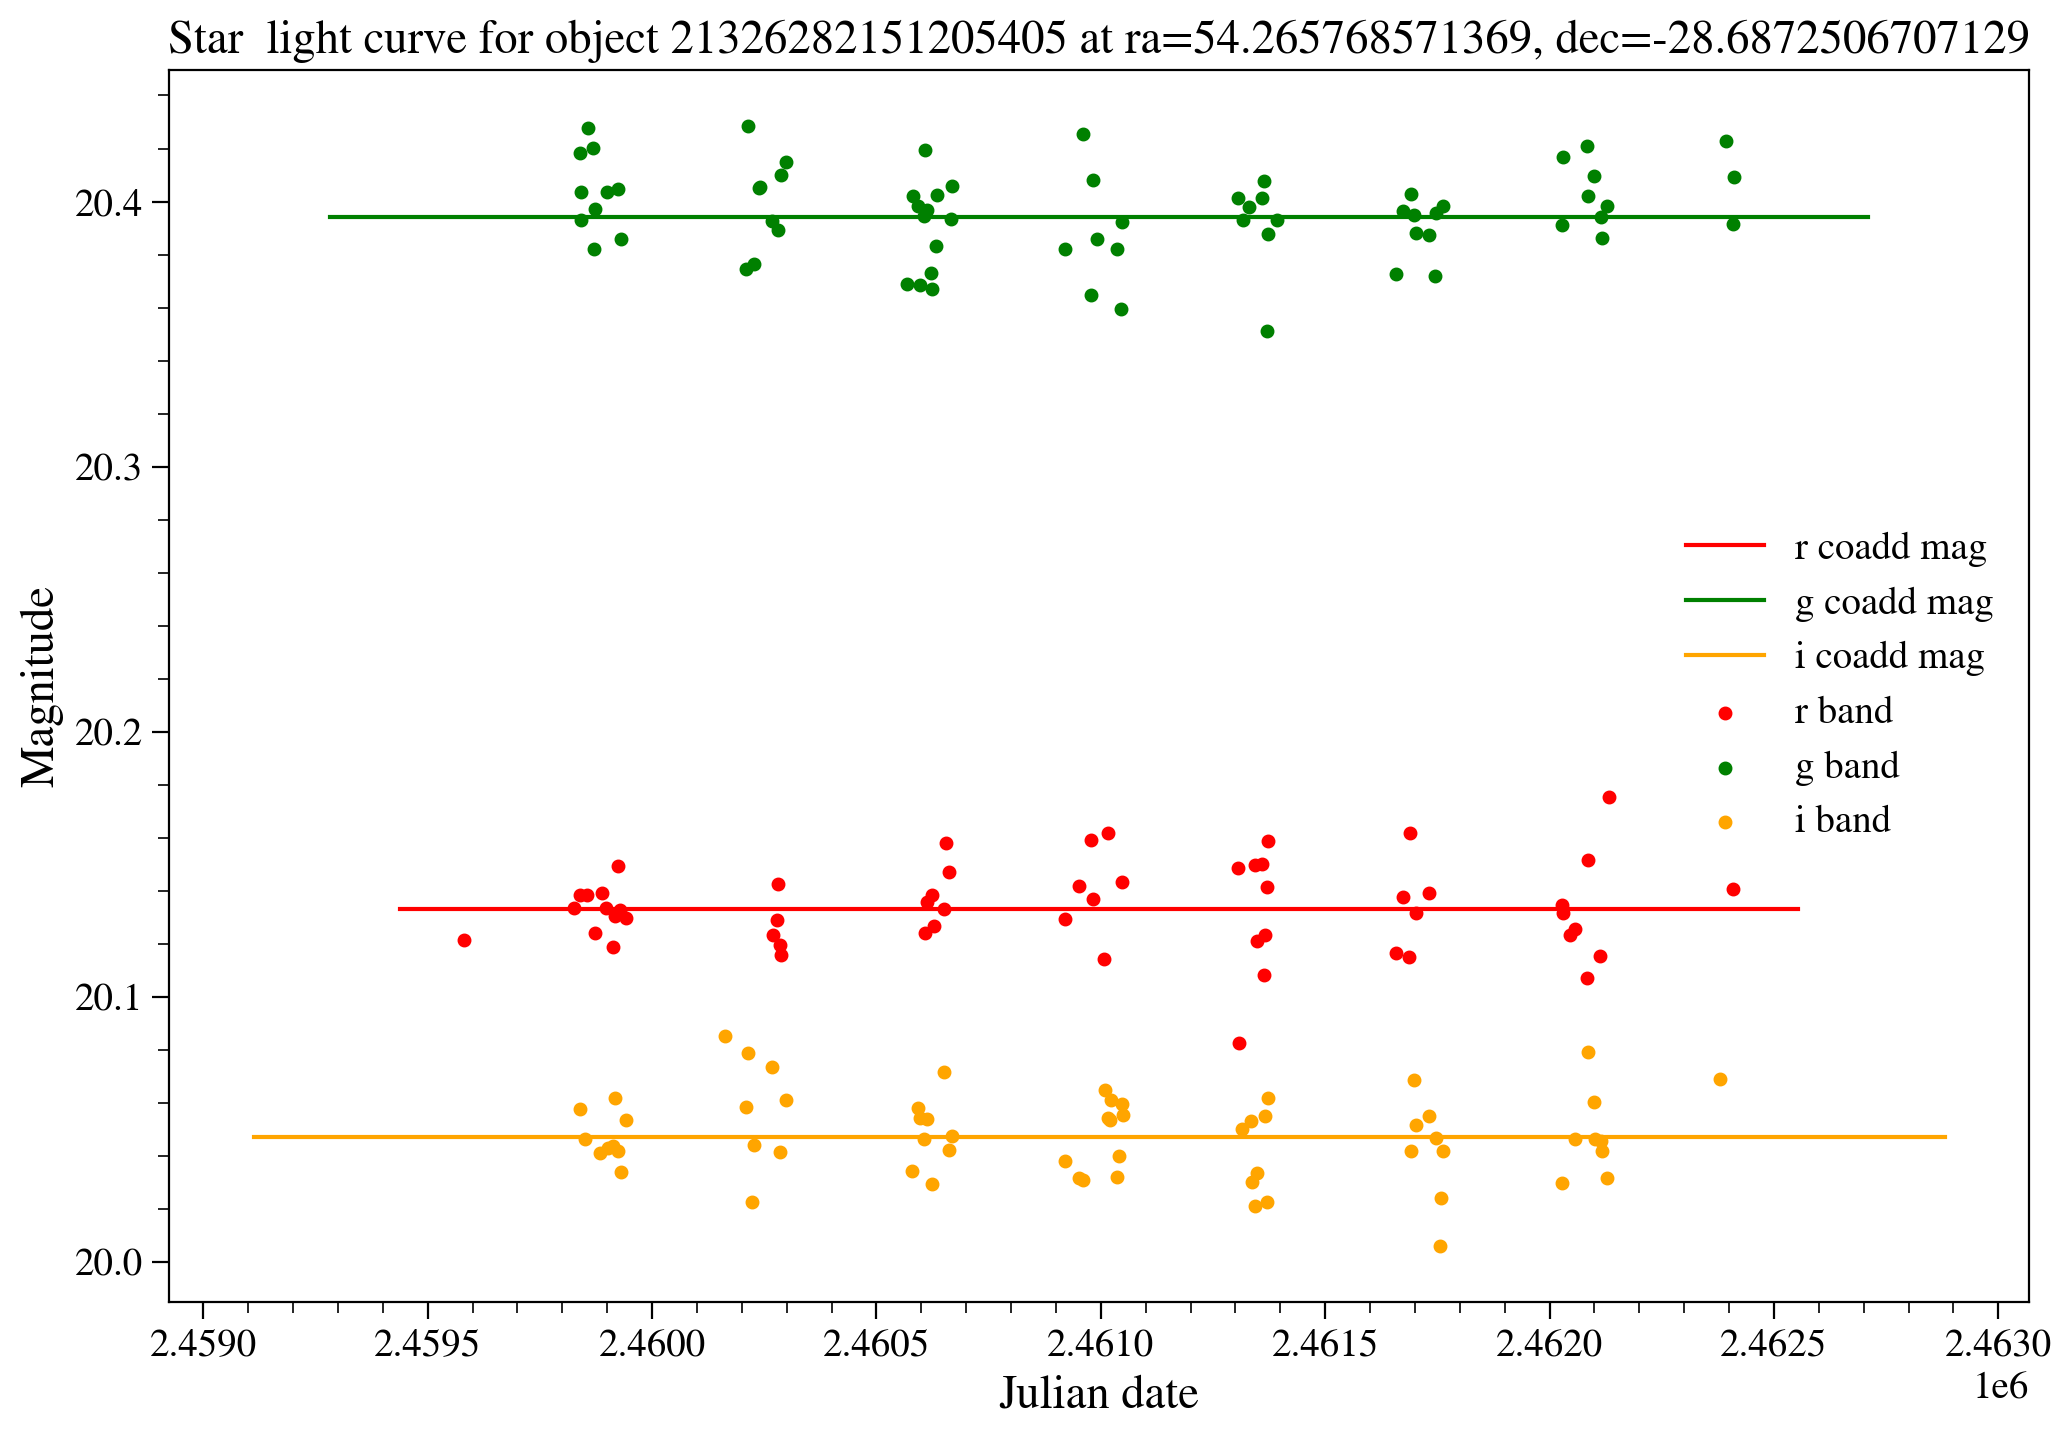

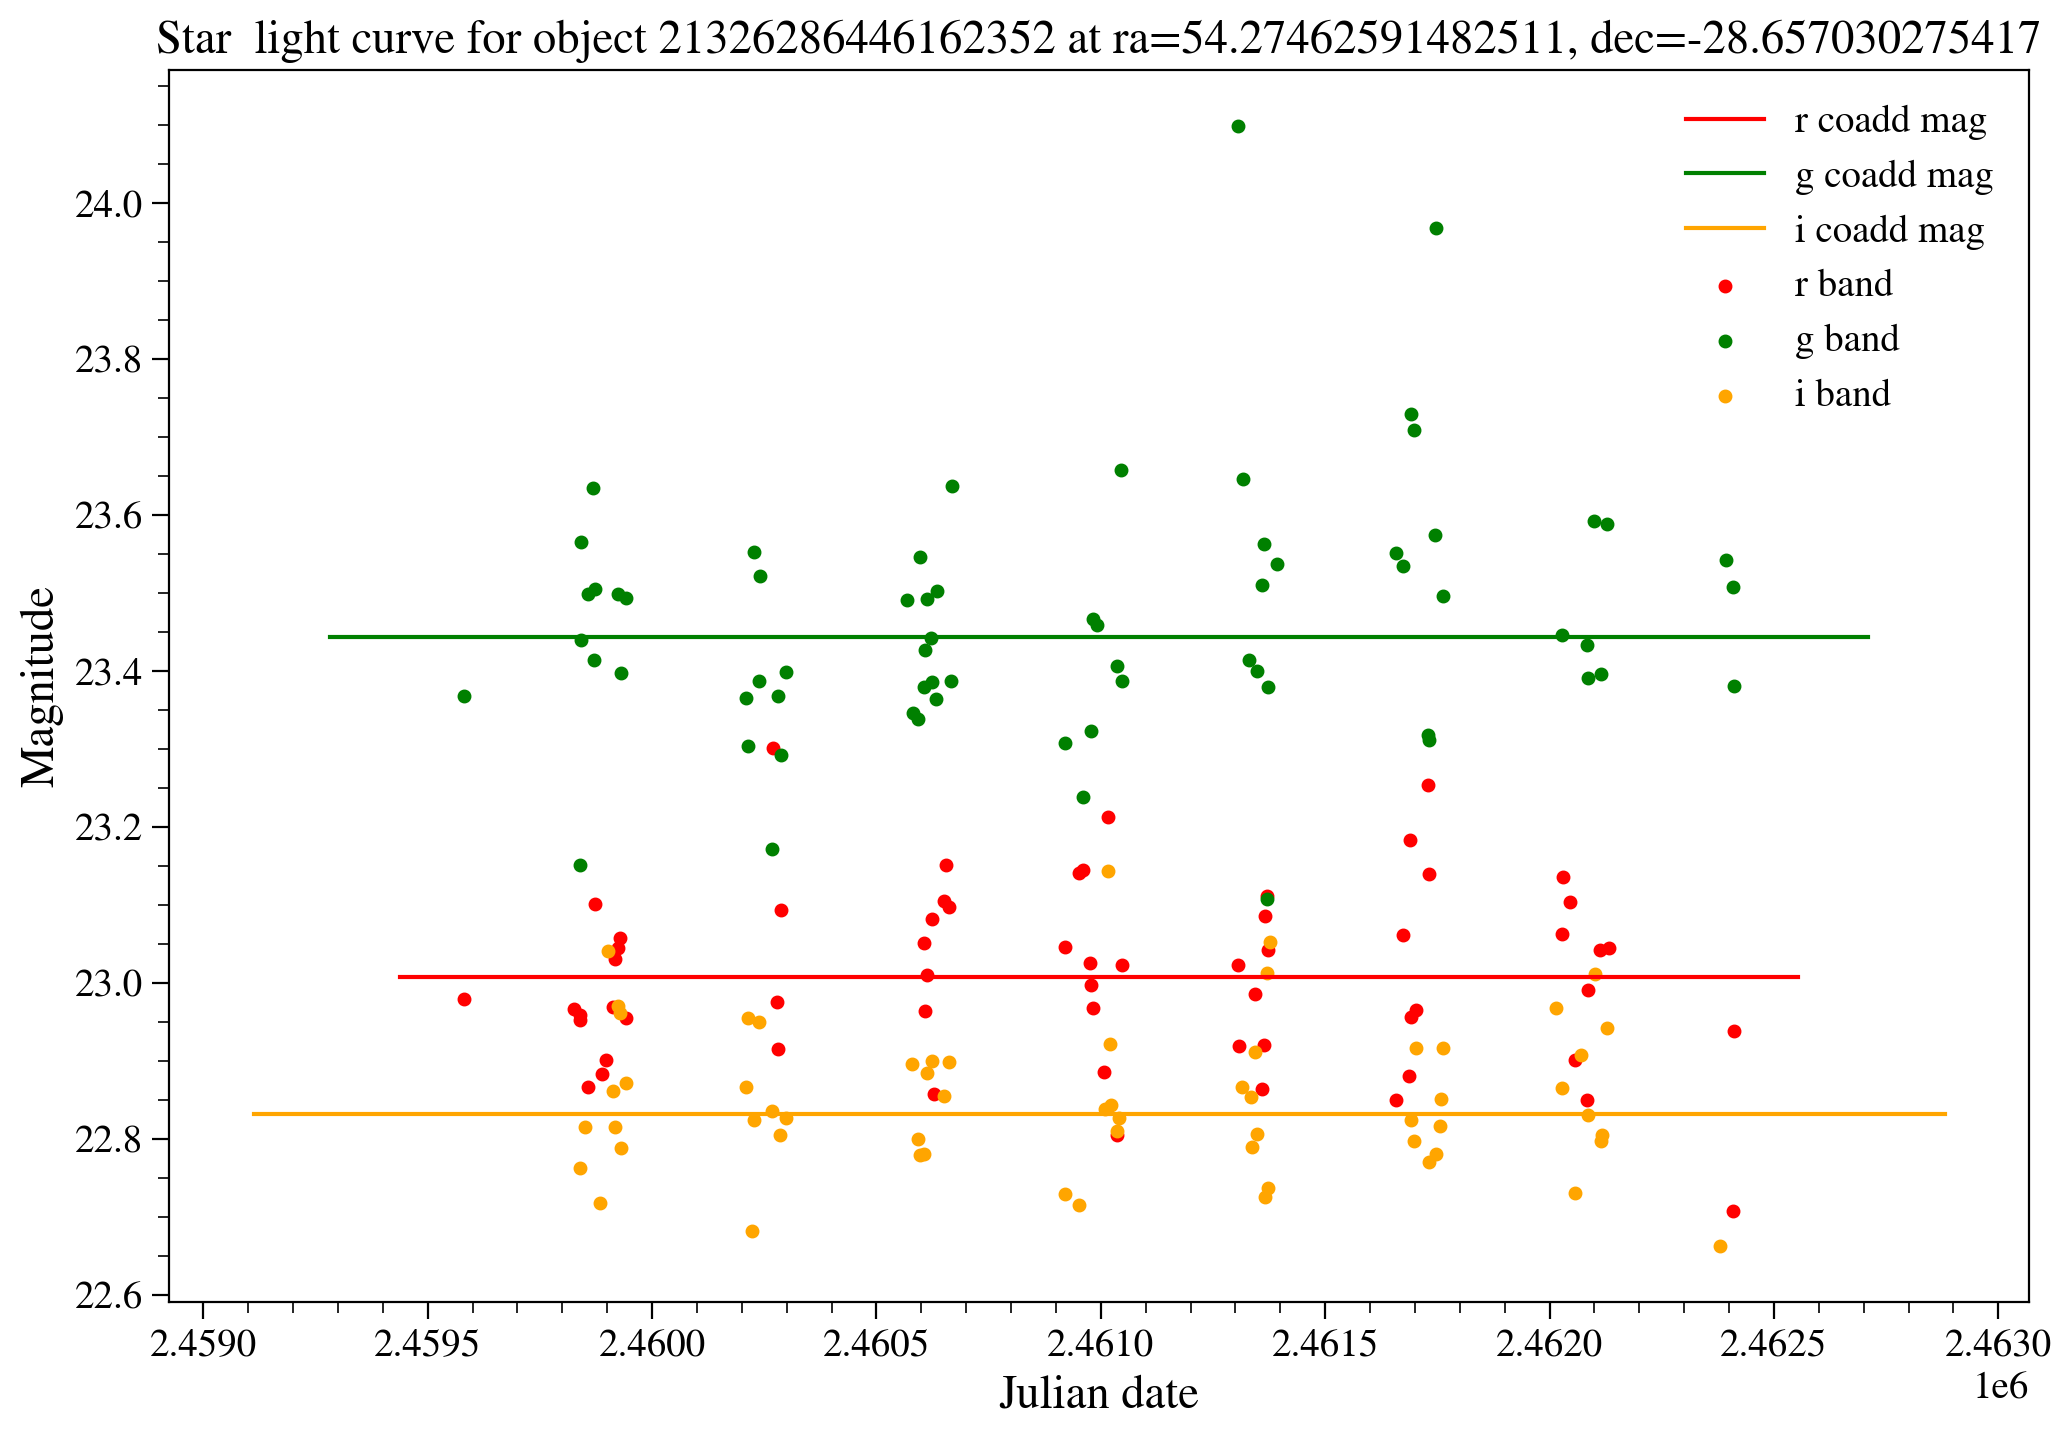

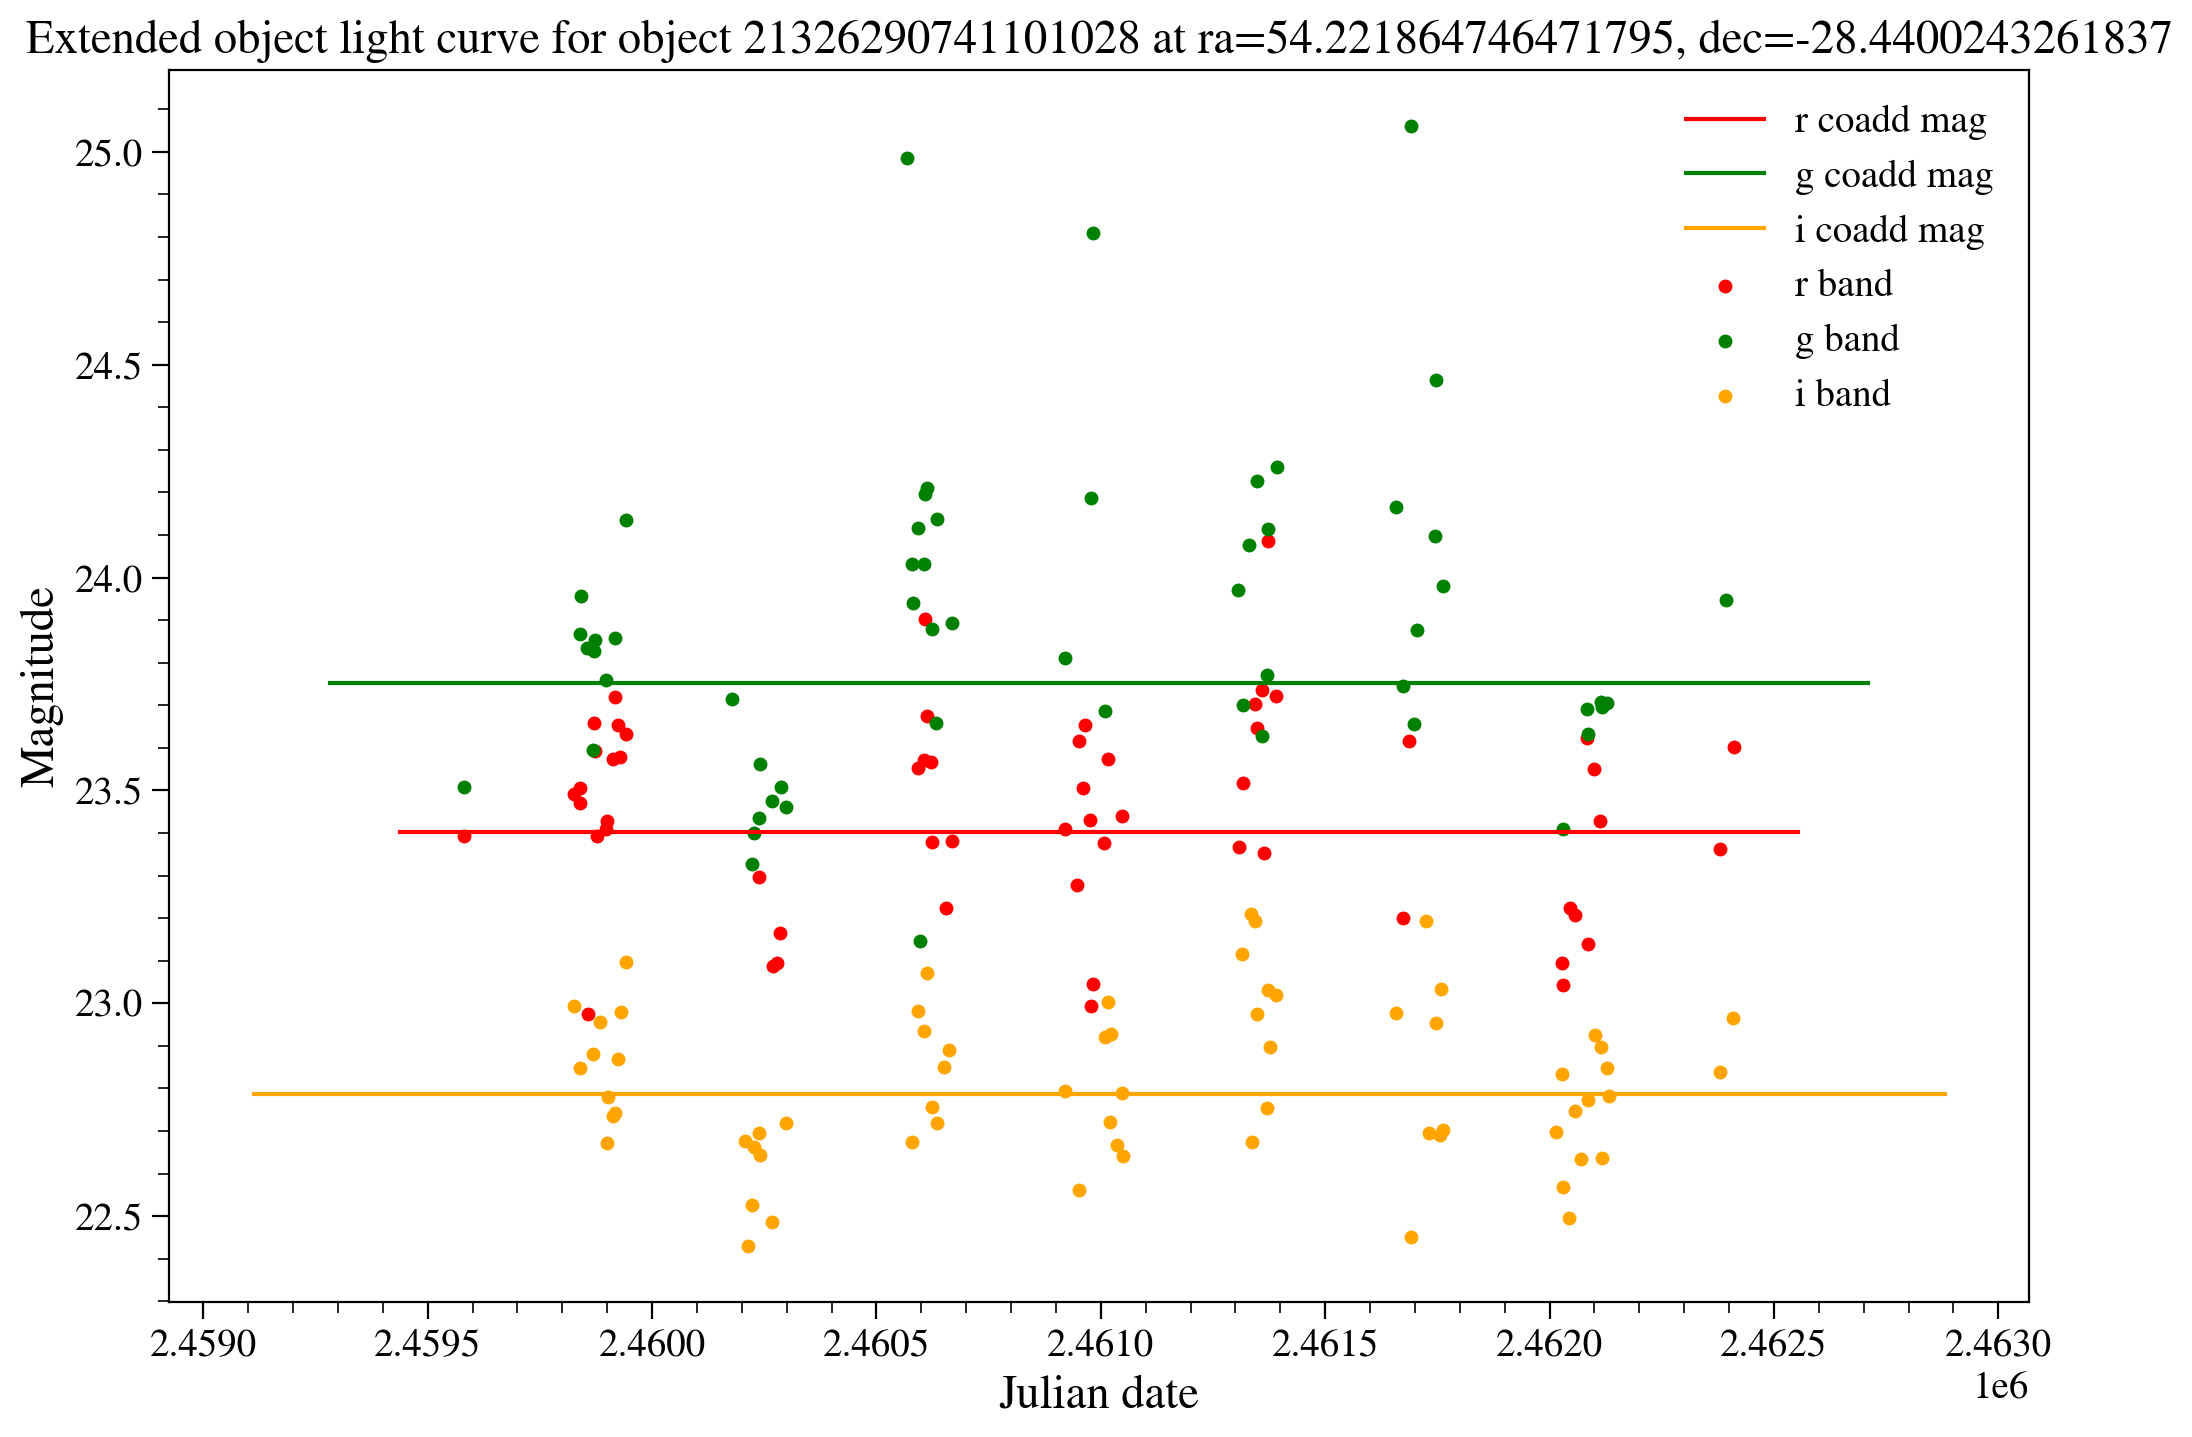

In [21]:
# Plot light curves for other objects chosen at random. 
for ix in [2, 13, 14]:
    oid = df['objectid'][ix]
    title = format_title(df,ix)
    the_data = getlc('run12p_v4', oid)
    coadd_mag = {'r' : df['mag_r'][ix], 'g' : df['mag_g'][ix], 'i' : df['mag_i'][ix]}
    plot_object(title, the_data, coadd_mag)